# Network Traffic Forecasting: Simulation Demo

This notebook validates the forecasting pipeline using synthetic data. 
It simulates multiple days of network traffic (sine waves with noise) to benchmark Prophet vs. DeepAR.

**Goal:** Train on historic cycles and predict the full next cycle (Next Day Forecast).

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# --- SYSTEM IMPORTS ---
from config import Config
from data_processor import DatasetMeta
from models import ProphetAdapter, DeepARAdapter
from visualizer import plot_model_comparison

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Configuration Strategy
We override specific `Config` defaults to suit the synthetic data environment. 

**Crucial Change for DeepAR:** We simulate **5 cycles** (days). Deep Learning models require sufficient repetition to separate signal from noise.

In [ ]:
# Initialize default config
cfg = Config()

# --- SIMULATION PARAMETERS ---
cfg.DT = 2.0               # 2-second granularity
CYCLE_LEN = 600            # Duration of one "day" pattern in seconds
NUM_CYCLES = 8             # More cycles = more learning signal for RNN

# --- MODEL HYPERPARAMETERS ---
cfg.EPOCHS = 60            # DeepAR needs longer training (compared to normal config) 
cfg.CONTEXT_LENGTH_MULTIPLIER = 2  # Give RNN 2 full cycles to learn

# --- DATA AUGMENTATION ---
cfg.AUGMENT_MULTIPLIER = 4  # 8 cycles → 32 effective cycles 
cfg.ADD_NOISE = True        # Regularization
cfg.NOISE_LEVEL = 1         # Less noise lets DeepAR learn clean signal

# --- SPLIT STRATEGY ---
total_bins = int((CYCLE_LEN * NUM_CYCLES) / cfg.DT)
bins_per_cycle = int(CYCLE_LEN / cfg.DT)

cfg.MAX_TEST_SAMPLES = bins_per_cycle
cfg.TEST_SPLIT_RATIO = 1.0 / NUM_CYCLES

print(f"Simulation Config: {NUM_CYCLES} Cycles of {CYCLE_LEN}s.")
print(f"After Augmentation: {total_bins * cfg.AUGMENT_MULTIPLIER} points")
print(f"Test Horizon: {bins_per_cycle} points (1 Cycle)")

Simulation Config: 8 Cycles of 600s.
After Augmentation: 9600 points
Test Horizon: 300 points (1 Cycle)


## 2. Data Generation Factory
We create a robust generator that mimics daily network traffic volume (Morning rise, Noon peak, Night lull).

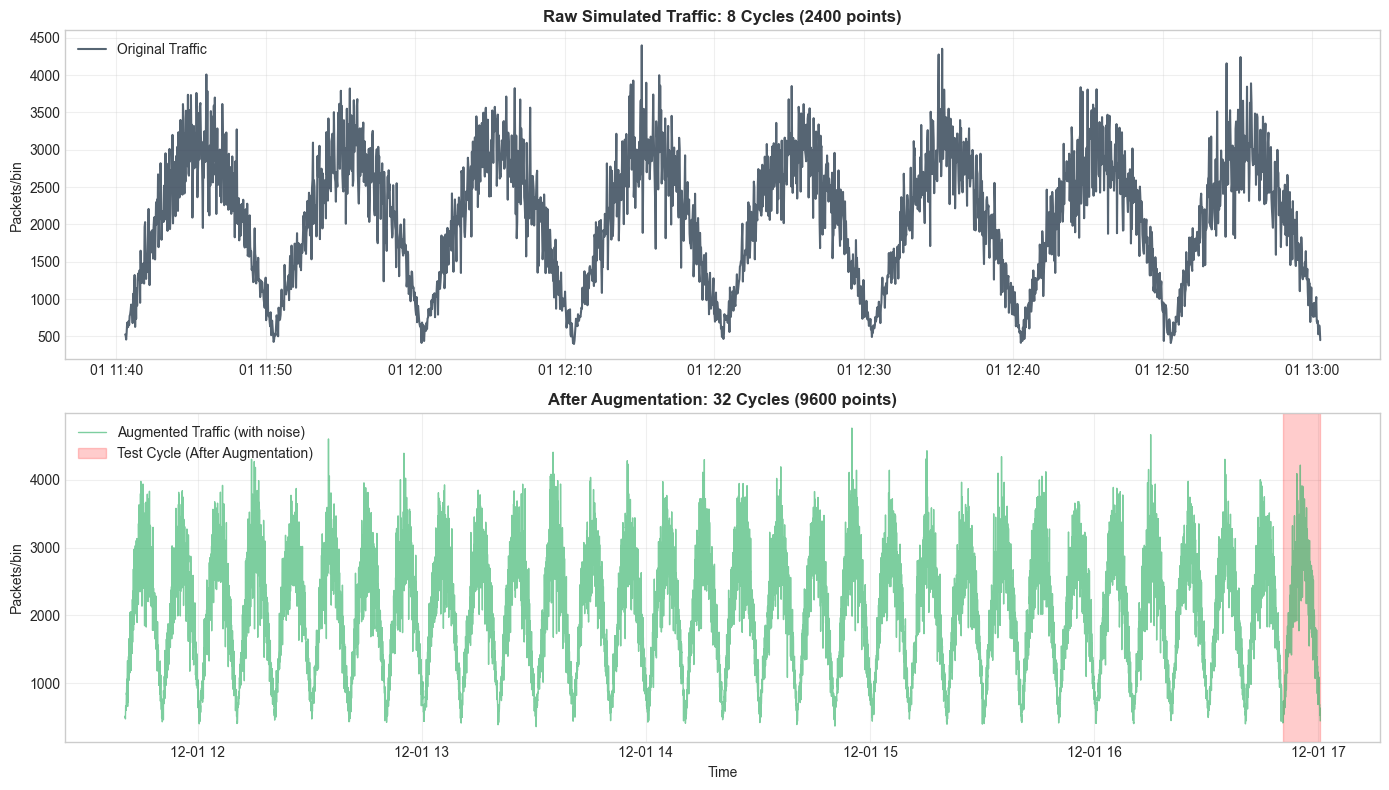


Data Pipeline Summary:
  Raw Data:        2400 points (8 cycles)
  After Augment:   9600 points (32 cycles)
  Train/Test Split: 9300 / 300
  Augmentation Method: Cycle repetition + 1% noise injection


In [6]:
def generate_traffic(config, cycle_len_sec, n_cycles):
    """Generates a sine-wave based traffic pattern with random noise."""
    steps_per_cycle = int(cycle_len_sec / config.DT)
    total_steps = steps_per_cycle * n_cycles
    
    # Build time axis from 0 to total_steps * DT
    t_vals = np.arange(total_steps) * config.DT
    start_date = datetime.now()
    timestamps = [start_date + timedelta(seconds=t) for t in t_vals]
    
    # Map each cycle to [0, π] so sin() produces 0 → 1 → 0 (day/night pattern)
    cycle_progress = (t_vals % cycle_len_sec) / cycle_len_sec * np.pi
    
    # Base 2 Mbps + 10 Mbps amplitude sine wave
    intensity = 2.0 + (10.0 * np.sin(cycle_progress))
    
    # Convert Mbps to packet counts: (Mbps * 1e6 * dt) / (8 bits/byte * ~1000 bytes/pkt)
    base_packets = (intensity * 1e6 * config.DT) / 8000
    
    # Heteroscedastic noise: variance scales with traffic volume (15%)
    noise_scale = base_packets * 0.15
    noise = np.random.normal(0, noise_scale, size=len(base_packets))
    
    # Floor at 10 packets to avoid negative values
    final_packets = np.maximum(10, base_packets + noise)
    
    df = pd.DataFrame({'timestamp': timestamps, 'target': final_packets})
    
    # Build metadata manually (bypassing DataProcessor)
    meta = DatasetMeta(
        period_seconds=cycle_len_sec,
        bins_per_cycle=steps_per_cycle,
        total_cycles=n_cycles,
        detection_method="Simulation (Manual)"
    )
    
    return df, meta

# Generate synthetic traffic
df_sim, meta = generate_traffic(cfg, CYCLE_LEN, NUM_CYCLES)

# --- Visualization: Before vs After Augmentation ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Raw generated data
ax1.plot(df_sim['timestamp'], df_sim['target'], color='#2c3e50', alpha=0.8, linewidth=1.5, label='Original Traffic')
test_start_idx = len(df_sim) - cfg.MAX_TEST_SAMPLES
ax1.set_title(f"Raw Simulated Traffic: {NUM_CYCLES} Cycles ({len(df_sim)} points)", fontsize=12, fontweight='bold')
ax1.set_ylabel("Packets/bin")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Simulate augmentation effect (multiply + add noise)
augmented_cycles = []
for i in range(cfg.AUGMENT_MULTIPLIER):
    # Multiplicative noise: mean=1.0, std=5% variation per sample
    noise_factor = np.random.normal(1.0, 0.05, size=len(df_sim))
    augmented_data = df_sim['target'].values * noise_factor
    augmented_data = np.maximum(10, augmented_data)  # Floor at 10
    augmented_cycles.append(augmented_data)

df_augmented = np.concatenate(augmented_cycles)
t_augmented = np.arange(len(df_augmented)) * cfg.DT
timestamps_aug = [df_sim['timestamp'].iloc[0] + timedelta(seconds=t) for t in t_augmented]

ax2.plot(timestamps_aug, df_augmented, color='#27ae60', alpha=0.6, linewidth=1.0, label='Augmented Traffic (with noise)')
test_start_aug = len(df_augmented) - cfg.MAX_TEST_SAMPLES
ax2.axvspan(timestamps_aug[test_start_aug], timestamps_aug[-1], 
            color='red', alpha=0.2, label='Test Cycle (After Augmentation)')
ax2.set_title(f"After Augmentation: {NUM_CYCLES * cfg.AUGMENT_MULTIPLIER} Cycles ({len(df_augmented)} points)", 
              fontsize=12, fontweight='bold')
ax2.set_ylabel("Packets/bin")
ax2.set_xlabel("Time")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nData Pipeline Summary:")
print(f"  Raw Data:        {len(df_sim)} points ({NUM_CYCLES} cycles)")
print(f"  After Augment:   {len(df_augmented)} points ({NUM_CYCLES * cfg.AUGMENT_MULTIPLIER} cycles)")
print(f"  Train/Test Split: {len(df_augmented) - cfg.MAX_TEST_SAMPLES} / {cfg.MAX_TEST_SAMPLES}")
print(f"  Augmentation Method: Cycle repetition + {cfg.NOISE_LEVEL}% noise injection")

## 3. Model Training & Evaluation
We run the models using the unified interface defined in `models.py`.

In [7]:
# Create augmented DataFrame for training
augmented_cycles = []
for i in range(cfg.AUGMENT_MULTIPLIER):
    noise_factor = np.random.normal(1.0, 0.05, size=len(df_sim))
    augmented_data = df_sim['target'].values * noise_factor
    augmented_data = np.maximum(10, augmented_data)
    augmented_cycles.append(augmented_data)

df_augmented_data = np.concatenate(augmented_cycles)
t_augmented = np.arange(len(df_augmented_data)) * cfg.DT
timestamps_aug = [df_sim['timestamp'].iloc[0] + timedelta(seconds=t) for t in t_augmented]

# Create DataFrame for training
df_train = pd.DataFrame({'timestamp': timestamps_aug, 'target': df_augmented_data})
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])

# --- train on augmented data ---
results_store = {}
metrics_store = []

pipeline = [
    ("Prophet", ProphetAdapter(cfg, meta)),
    ("DeepAR", DeepARAdapter(cfg, meta))
]

print("--- Pipeline Execution ---")
for name, model in pipeline:
    print(f"\n> Processing {name}...")
    
    # 1. Prepare (Split)
    model.prepare_data(df_train)
    
    # 2. Train
    model.train()
    
    # 3. Predict
    forecast_df = model.predict()
    results_store[name] = forecast_df
    
    # 4. Metric Calculation
    mae = (forecast_df['actual'] - forecast_df['mean']).abs().mean()
    rmse = np.sqrt(((forecast_df['actual'] - forecast_df['mean']) ** 2).mean())
    print(f"  {name} MAE: {mae:.2f} | RMSE: {rmse:.2f}")

print("\nDone.")

--- Pipeline Execution ---

> Processing Prophet...

Train/Test Split (88/12):
   Train: 9300 samples (96.9%)
   Test:  300 samples (3.1%)


11:40:35 - cmdstanpy - INFO - Chain [1] start processing
11:40:35 - cmdstanpy - INFO - Chain [1] done processing
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  Prophet MAE: 266.45 | RMSE: 351.27

> Processing DeepAR...

Train/Test Split (88/12):
   Train: 9300 samples (96.9%)
   Test:  300 samples (3.1%)



  | Name  | Type        | Params | Mode  | In sizes                                                       | Out sizes    
-------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 25.1 K | train | [[1, 1], [1, 1], [1, 691, 7], [1, 691], [1, 691], [1, 300, 7]] | [1, 100, 300]
-------------------------------------------------------------------------------------------------------------------------------
25.1 K    Trainable params
0         Non-trainable params
25.1 K    Total params
0.100     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 0: |          | 50/? [00:10<00:00,  4.69it/s, v_num=14, train_loss=8.100]

Epoch 0, global step 50: 'train_loss' reached 8.09690 (best 8.09690), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_14/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:08<00:00,  5.72it/s, v_num=14, train_loss=7.220]

Epoch 1, global step 100: 'train_loss' reached 7.21748 (best 7.21748), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_14/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:08<00:00,  5.89it/s, v_num=14, train_loss=7.060]

Epoch 2, global step 150: 'train_loss' reached 7.05695 (best 7.05695), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_14/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:08<00:00,  5.73it/s, v_num=14, train_loss=7.020]

Epoch 3, global step 200: 'train_loss' reached 7.02333 (best 7.02333), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_14/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:08<00:00,  5.95it/s, v_num=14, train_loss=7.020]

Epoch 4, global step 250: 'train_loss' reached 7.02138 (best 7.02138), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_14/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:08<00:00,  5.80it/s, v_num=14, train_loss=7.010]

Epoch 5, global step 300: 'train_loss' reached 7.01403 (best 7.01403), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_14/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:08<00:00,  5.88it/s, v_num=14, train_loss=6.990]

Epoch 6, global step 350: 'train_loss' reached 6.98829 (best 6.98829), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_14/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [00:08<00:00,  5.79it/s, v_num=14, train_loss=6.990]

Epoch 7, global step 400: 'train_loss' was not in top 1


Epoch 8: |          | 50/? [00:08<00:00,  5.77it/s, v_num=14, train_loss=6.980]

Epoch 8, global step 450: 'train_loss' reached 6.97858 (best 6.97858), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_14/checkpoints/epoch=8-step=450.ckpt' as top 1


Epoch 9: |          | 50/? [00:08<00:00,  6.03it/s, v_num=14, train_loss=6.970]

Epoch 9, global step 500: 'train_loss' reached 6.96819 (best 6.96819), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_14/checkpoints/epoch=9-step=500.ckpt' as top 1


Epoch 10: |          | 50/? [00:09<00:00,  5.50it/s, v_num=14, train_loss=6.980]

Epoch 10, global step 550: 'train_loss' was not in top 1


Epoch 11: |          | 50/? [00:08<00:00,  5.65it/s, v_num=14, train_loss=7.000]

Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: |          | 50/? [00:09<00:00,  5.52it/s, v_num=14, train_loss=6.980]

Epoch 12, global step 650: 'train_loss' was not in top 1


Epoch 13: |          | 50/? [00:08<00:00,  5.82it/s, v_num=14, train_loss=6.980]

Epoch 13, global step 700: 'train_loss' was not in top 1


Epoch 14: |          | 50/? [00:08<00:00,  5.98it/s, v_num=14, train_loss=6.980]

Epoch 14, global step 750: 'train_loss' was not in top 1


Epoch 15: |          | 50/? [00:08<00:00,  5.85it/s, v_num=14, train_loss=6.970]

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: |          | 50/? [00:08<00:00,  5.85it/s, v_num=14, train_loss=6.940]

Epoch 16, global step 850: 'train_loss' reached 6.94206 (best 6.94206), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_14/checkpoints/epoch=16-step=850.ckpt' as top 1


Epoch 17: |          | 50/? [00:08<00:00,  6.04it/s, v_num=14, train_loss=6.970]

Epoch 17, global step 900: 'train_loss' was not in top 1


Epoch 18: |          | 50/? [00:08<00:00,  5.98it/s, v_num=14, train_loss=6.920]

Epoch 18, global step 950: 'train_loss' reached 6.91821 (best 6.91821), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_14/checkpoints/epoch=18-step=950.ckpt' as top 1


Epoch 19: |          | 50/? [00:08<00:00,  5.99it/s, v_num=14, train_loss=6.950]

Epoch 19, global step 1000: 'train_loss' was not in top 1


Epoch 20: |          | 50/? [00:08<00:00,  5.85it/s, v_num=14, train_loss=6.960]

Epoch 20, global step 1050: 'train_loss' was not in top 1


Epoch 21: |          | 50/? [00:08<00:00,  6.01it/s, v_num=14, train_loss=6.940]

Epoch 21, global step 1100: 'train_loss' was not in top 1


Epoch 22: |          | 50/? [00:08<00:00,  6.14it/s, v_num=14, train_loss=6.950]

Epoch 22, global step 1150: 'train_loss' was not in top 1


Epoch 23: |          | 50/? [00:08<00:00,  5.79it/s, v_num=14, train_loss=6.930]

Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: |          | 50/? [00:08<00:00,  6.02it/s, v_num=14, train_loss=6.950]

Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: |          | 50/? [00:08<00:00,  6.08it/s, v_num=14, train_loss=6.960]

Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: |          | 50/? [00:09<00:00,  5.23it/s, v_num=14, train_loss=6.940]

Epoch 26, global step 1350: 'train_loss' was not in top 1


Epoch 27: |          | 50/? [00:08<00:00,  5.67it/s, v_num=14, train_loss=6.960]

Epoch 27, global step 1400: 'train_loss' was not in top 1


Epoch 28: |          | 50/? [00:08<00:00,  6.10it/s, v_num=14, train_loss=6.940]

Epoch 28, global step 1450: 'train_loss' was not in top 1


Epoch 29: |          | 50/? [00:08<00:00,  6.07it/s, v_num=14, train_loss=6.950]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: |          | 50/? [00:08<00:00,  6.17it/s, v_num=14, train_loss=6.930]

Epoch 30, global step 1550: 'train_loss' was not in top 1


Epoch 31: |          | 50/? [00:08<00:00,  5.86it/s, v_num=14, train_loss=6.920]

Epoch 31, global step 1600: 'train_loss' was not in top 1


Epoch 32: |          | 50/? [00:09<00:00,  5.15it/s, v_num=14, train_loss=6.940]

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: |          | 50/? [00:10<00:00,  4.70it/s, v_num=14, train_loss=6.940]

Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: |          | 50/? [00:11<00:00,  4.52it/s, v_num=14, train_loss=6.920]

Epoch 34, global step 1750: 'train_loss' was not in top 1


Epoch 35: |          | 50/? [00:10<00:00,  4.61it/s, v_num=14, train_loss=6.920]

Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: |          | 50/? [00:11<00:00,  4.44it/s, v_num=14, train_loss=6.920]

Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: |          | 50/? [00:09<00:00,  5.05it/s, v_num=14, train_loss=6.920]

Epoch 37, global step 1900: 'train_loss' was not in top 1


Epoch 38: |          | 50/? [00:12<00:00,  3.86it/s, v_num=14, train_loss=6.900]

Epoch 38, global step 1950: 'train_loss' reached 6.89911 (best 6.89911), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_14/checkpoints/epoch=38-step=1950.ckpt' as top 1


Epoch 39: |          | 50/? [00:12<00:00,  3.91it/s, v_num=14, train_loss=6.900]

Epoch 39, global step 2000: 'train_loss' reached 6.89603 (best 6.89603), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_14/checkpoints/epoch=39-step=2000.ckpt' as top 1


Epoch 40: |          | 50/? [00:12<00:00,  3.99it/s, v_num=14, train_loss=6.930]

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: |          | 50/? [00:10<00:00,  4.73it/s, v_num=14, train_loss=6.900]

Epoch 41, global step 2100: 'train_loss' was not in top 1


Epoch 42: |          | 50/? [00:10<00:00,  4.70it/s, v_num=14, train_loss=6.890]

Epoch 42, global step 2150: 'train_loss' reached 6.89401 (best 6.89401), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_14/checkpoints/epoch=42-step=2150.ckpt' as top 1


Epoch 43: |          | 50/? [00:09<00:00,  5.16it/s, v_num=14, train_loss=6.900]

Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: |          | 50/? [00:11<00:00,  4.33it/s, v_num=14, train_loss=6.900]

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: |          | 50/? [00:13<00:00,  3.68it/s, v_num=14, train_loss=6.880]

Epoch 45, global step 2300: 'train_loss' reached 6.87687 (best 6.87687), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_14/checkpoints/epoch=45-step=2300.ckpt' as top 1


Epoch 46: |          | 50/? [00:11<00:00,  4.26it/s, v_num=14, train_loss=6.900]

Epoch 46, global step 2350: 'train_loss' was not in top 1


Epoch 47: |          | 50/? [00:12<00:00,  4.15it/s, v_num=14, train_loss=6.890]

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: |          | 50/? [00:11<00:00,  4.44it/s, v_num=14, train_loss=6.900]

Epoch 48, global step 2450: 'train_loss' was not in top 1


Epoch 49: |          | 50/? [00:09<00:00,  5.16it/s, v_num=14, train_loss=6.900]

Epoch 49, global step 2500: 'train_loss' was not in top 1


Epoch 50: |          | 50/? [00:12<00:00,  3.88it/s, v_num=14, train_loss=6.870]

Epoch 50, global step 2550: 'train_loss' reached 6.87245 (best 6.87245), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_14/checkpoints/epoch=50-step=2550.ckpt' as top 1


Epoch 51: |          | 50/? [00:11<00:00,  4.38it/s, v_num=14, train_loss=6.840]

Epoch 51, global step 2600: 'train_loss' reached 6.84500 (best 6.84500), saving model to '/home/elia/university/net2/ml-traffic-prediction/lightning_logs/version_14/checkpoints/epoch=51-step=2600.ckpt' as top 1


Epoch 52: |          | 50/? [00:10<00:00,  4.81it/s, v_num=14, train_loss=6.880]

Epoch 52, global step 2650: 'train_loss' was not in top 1


Epoch 53: |          | 50/? [00:09<00:00,  5.15it/s, v_num=14, train_loss=6.880]

Epoch 53, global step 2700: 'train_loss' was not in top 1


Epoch 54: |          | 50/? [00:10<00:00,  4.87it/s, v_num=14, train_loss=6.890]

Epoch 54, global step 2750: 'train_loss' was not in top 1


Epoch 55: |          | 50/? [00:11<00:00,  4.35it/s, v_num=14, train_loss=6.880]

Epoch 55, global step 2800: 'train_loss' was not in top 1


Epoch 56: |          | 50/? [00:10<00:00,  4.75it/s, v_num=14, train_loss=6.870]

Epoch 56, global step 2850: 'train_loss' was not in top 1


Epoch 57: |          | 50/? [00:10<00:00,  4.99it/s, v_num=14, train_loss=6.860]

Epoch 57, global step 2900: 'train_loss' was not in top 1


Epoch 58: |          | 50/? [00:10<00:00,  4.70it/s, v_num=14, train_loss=6.880]

Epoch 58, global step 2950: 'train_loss' was not in top 1


Epoch 59: |          | 50/? [00:10<00:00,  4.63it/s, v_num=14, train_loss=6.850]

Epoch 59, global step 3000: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch 59: |          | 50/? [00:10<00:00,  4.62it/s, v_num=14, train_loss=6.850]
  DeepAR MAE: 261.21 | RMSE: 350.88

Done.


## 4. Visualization
Comparing the actual ground truth against the model forecasts.

✓ Saved comparison plot: output/demo_days_results.png


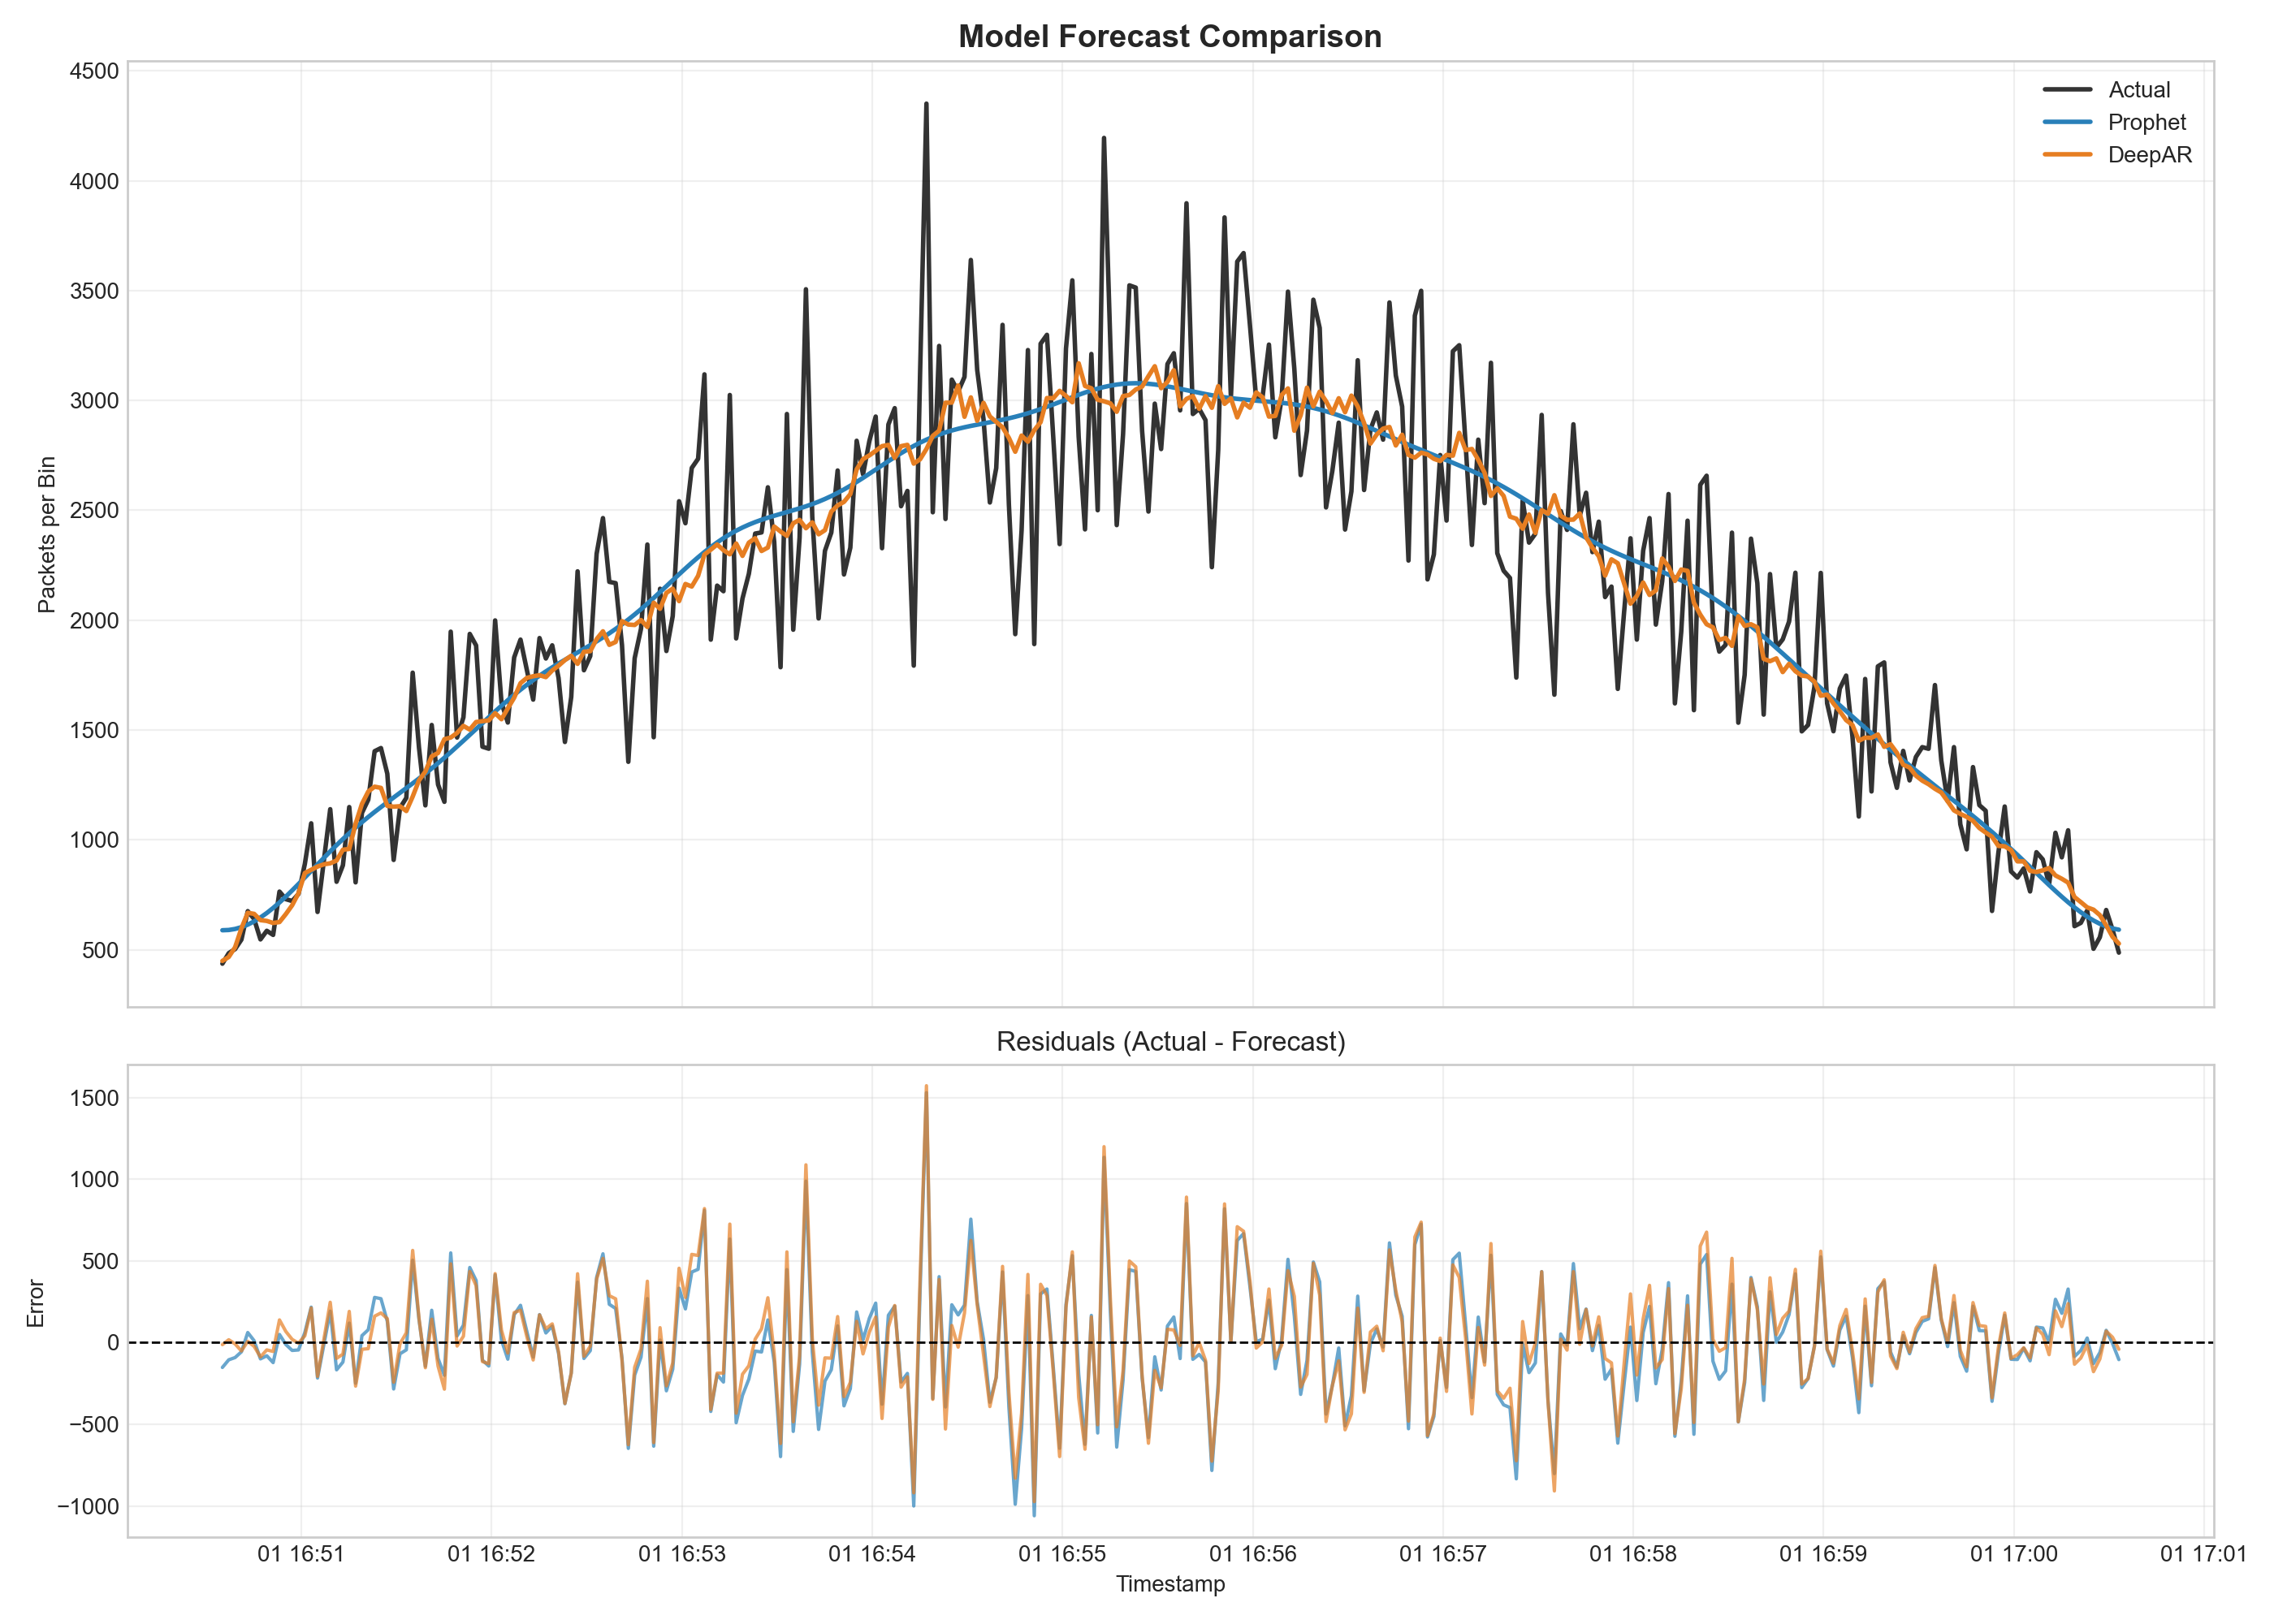

In [8]:
output_file = cfg.OUTPUT_DIR / "demo_days_results.png"
plot_model_comparison(results_store, output_file)

# Display in Notebook
from IPython.display import Image, display
display(Image(filename=output_file))